In [1]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 4.6 MB/s eta 0:00:00:00:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 144.3 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 23.9 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


In [49]:
pip install --upgrade catboost

Note: you may need to restart the kernel to use updated packages.


In [38]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 2.3 MB/s eta 0:00:00:00:01
Note: you may need to restart the kernel to use updated packages.


In [71]:
pip install imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 770.2 kB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score  # for classification
from sklearn.metrics import roc_auc_score  # for classification
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [2]:
#Load data

data_test = pd.read_csv('test.csv')
data_train = pd.read_csv('train.csv')
X = data_train.copy()
del X['loan_status']
y = data_train.copy()
y = y['loan_status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [3]:
class_distribution = y.value_counts()
print(class_distribution)

loan_status
0    50295
1     8350
Name: count, dtype: int64


In [4]:
# Identify categorical features
categorical_features = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()  # Get numerical features

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a ColumnTransformer to apply One-Hot Encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),  # Apply One-Hot Encoding to categorical features
        ('num', 'passthrough', numerical_features)  # Keep numerical features as is
    ]
)

# Fit and transform the training data
X_train_processed = preprocessor.fit_transform(X_train)

# Apply SMOTE to the processed training data
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_processed, y_train)

# Check the distribution of the classes after resampling
print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", pd.Series(y_resampled).value_counts())

Before SMOTE: loan_status
0    40208
1     6708
Name: count, dtype: int64
After SMOTE: loan_status
0    40208
1    40208
Name: count, dtype: int64


In [5]:
# Fit the CatBoost model with resampled data
model = CatBoostClassifier(iterations=1000, depth=6, learning_rate=0.1, verbose=100, task_type='CPU')
model.fit(X_resampled, y_resampled)  # No cat_features since they are already encoded

# Transform the test data
X_test_processed = preprocessor.transform(X_test)

# Make predictions on the test set
y_pred = model.predict_proba(X_test_processed)[:, 1]  # Get probabilities for the positive class
roc = roc_auc_score(y_test, y_pred)  # Calculate ROC AUC score

print("ROC AUC score:", roc)

0:	learn: 0.5612079	total: 66.2ms	remaining: 1m 6s
100:	learn: 0.1017546	total: 2s	remaining: 17.8s
200:	learn: 0.0895941	total: 3.93s	remaining: 15.6s
300:	learn: 0.0817869	total: 6s	remaining: 13.9s
400:	learn: 0.0761630	total: 7.95s	remaining: 11.9s
500:	learn: 0.0713920	total: 9.92s	remaining: 9.88s
600:	learn: 0.0673814	total: 12.1s	remaining: 8.01s
700:	learn: 0.0639125	total: 14.1s	remaining: 6.01s
800:	learn: 0.0606823	total: 16.1s	remaining: 4s
900:	learn: 0.0574787	total: 18.2s	remaining: 2s
999:	learn: 0.0545974	total: 20.2s	remaining: 0us
ROC AUC score: 0.954488640665431


In [ ]:
#OPTIMISATION BEGINS

In [ ]:
import optuna
import numpy as np
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold  # Import StratifiedKFold
from sklearn.metrics import roc_auc_score

# Define the Optuna objective function
def objective(trial):
    # Hyperparameters to tune
    params = {
        "iterations": trial.suggest_int("iterations", 100, 1000),  # Reasonable upper limit for iterations
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),  # Standard learning rate range
        "depth": trial.suggest_int("depth", 4, 10),  # Allow more flexibility in tree depth
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1, 5),  # Regularization strength
        "random_strength": trial.suggest_float("random_strength", 1, 3),  # Randomness control
        "od_type": trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),  # Overfitting detection type
        "od_wait": trial.suggest_int("od_wait", 10, 50),  # Waiting time for overfitting detection
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bernoulli"]),  # Bootstrapping method
        "task_type": 'CPU',  # Use CPU for training
        "verbose": False  # Suppress verbose output
    }

    # Conditional addition of bagging_temperature based on bootstrap_type
    bootstrap_type = params["bootstrap_type"]
    if bootstrap_type == "Bayesian":
        params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0.0, 10.0)

    # Initialize StratifiedKFold
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)  # Using StratifiedKFold for stratified sampling
    roc_auc_scores = []

    # Perform k-fold cross-validation
    for train_index, val_index in skf.split(X_resampled, y_resampled):
        X_train, X_val = X_resampled[train_index], X_resampled[val_index]
        y_train, y_val = y_resampled[train_index], y_resampled[val_index]

        model = CatBoostClassifier(**params)
        
        # Fit the model
        model.fit(X_train, y_train, verbose=False)

        # Predict and calculate ROC AUC score
        y_pred = model.predict_proba(X_val)[:, 1]  # Get probabilities for the positive class
        roc = roc_auc_score(y_val, y_pred)  # Calculate ROC AUC score
        roc_auc_scores.append(roc)

    # Return the mean ROC AUC score across folds
    return np.mean(roc_auc_scores)
    
# Create a study and optimize the objective function
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print("Best parameters:", study.best_params)
print("Best ROC AUC:", study.best_value)

# Fit the final model with the best parameters
best_params = study.best_params
best_params['verbose'] = 100  # Adjust verbosity

# Fit the model with the best parameters
model = CatBoostClassifier(**best_params)
model.fit(X_resampled, y_resampled)  # Fit with the best parameters

[I 2024-10-08 18:48:09,603] A new study created in memory with name: no-name-a2dbaa98-13c8-4d67-9a85-3a6b0eb8bddd
[I 2024-10-08 18:49:14,491] Trial 0 finished with value: 0.9871328823316547 and parameters: {'iterations': 294, 'learning_rate': 0.01767097849963275, 'depth': 6, 'l2_leaf_reg': 4.509125303495586, 'random_strength': 2.8506910244757533, 'od_type': 'IncToDec', 'od_wait': 46, 'bootstrap_type': 'Bernoulli'}. Best is trial 0 with value: 0.9871328823316547.
[I 2024-10-08 18:51:26,032] Trial 1 finished with value: 0.9851061424643008 and parameters: {'iterations': 194, 'learning_rate': 0.006554124535622083, 'depth': 9, 'l2_leaf_reg': 4.7498248156076075, 'random_strength': 1.5317271460799093, 'od_type': 'IncToDec', 'od_wait': 31, 'bootstrap_type': 'Bernoulli'}. Best is trial 0 with value: 0.9871328823316547.
[I 2024-10-08 18:55:14,539] Trial 2 finished with value: 0.9913936996905827 and parameters: {'iterations': 615, 'learning_rate': 0.04499346790707977, 'depth': 8, 'l2_leaf_reg': 4

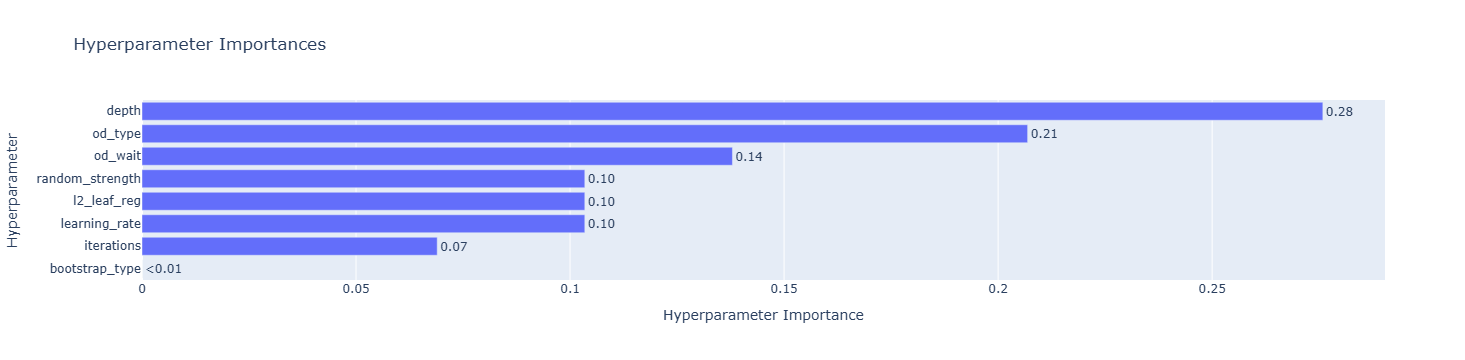

In [43]:
from optuna.visualization import plot_param_importances

fig = plot_param_importances(study)
fig.show()

In [44]:
import numpy as np

# Get the feature importances from the model
importances = model.get_feature_importance()

# Get the feature names from the preprocessor
# This step is crucial as OneHotEncoder creates new feature names
cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
feature_names = np.concatenate([cat_feature_names, numerical_features])

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the feature importances
print(feature_importance_df)

                           Feature  Importance
25             loan_percent_income   18.743718
24                   loan_int_rate   14.522632
3       person_home_ownership_RENT   10.233246
21                   person_income    9.132879
22               person_emp_length    6.760676
19                              id    6.712179
13                    loan_grade_D    4.812724
23                       loan_amnt    4.471736
20                      person_age    4.136543
26      cb_person_cred_hist_length    3.124188
9              loan_intent_VENTURE    2.579157
6      loan_intent_HOMEIMPROVEMENT    2.077404
12                    loan_grade_C    2.054316
4    loan_intent_DEBTCONSOLIDATION    2.053923
7              loan_intent_MEDICAL    1.861815
2        person_home_ownership_OWN    1.379209
0   person_home_ownership_MORTGAGE    1.350066
5            loan_intent_EDUCATION    1.018556
8             loan_intent_PERSONAL    1.016140
17     cb_person_default_on_file_N    0.738900
18     cb_per

In [34]:
print("Best parameters:", study.best_params)
print("Best ROC AUC:", study.best_value)

# Fit the final model with the best parameters
best_params = study.best_params
best_params['verbose'] = 100  # Adjust verbosity

# Fit the model with the best parameters
model = CatBoostClassifier(**best_params)
model.fit(X_train_processed, y_train)  # Fit with the best parameters

Best parameters: {'iterations': 300, 'learning_rate': 0.01425901557425916, 'depth': 5, 'l2_leaf_reg': 2.531205462159521, 'random_strength': 0.7223475019421237, 'od_type': 'Iter', 'od_wait': 21, 'bootstrap_type': 'Bernoulli'}
Best ROC AUC: 0.9868667152323619
0:	learn: 0.6745349	total: 8.07ms	remaining: 2.41s
100:	learn: 0.2139599	total: 797ms	remaining: 1.57s
200:	learn: 0.1853114	total: 1.65s	remaining: 813ms
299:	learn: 0.1758558	total: 2.41s	remaining: 0us


In [35]:
y_pred = model.predict_proba(X_test_processed)[:, 1]  # Get probabilities for the positive class
roc = roc_auc_score(y_test, y_pred)  # Calculate ROC AUC score
print(roc)

0.9348435963995094


In [33]:
# Assuming 'data_test' is your test dataset
X_ = data_test.copy()

# Preprocess the test data
X_processed = preprocessor.transform(X_)  # Apply the same preprocessor as for training data

# Make predictions using the model
y_ = model.predict_proba(X_processed)[:, 1]  # Get probabilities for the positive class

# Compile solution
solution = {
    'id': X_['id'],  # Make sure 'id' column exists in data_test
    'loan_status': y_
}

# Create DataFrame and save to CSV
df = pd.DataFrame(solution)
df.to_csv('solution.csv', index=False)  # Add .csv extension to the output file